
# Single-Cell RNA-seq Analysis with scVI (Adapted for TSV File)
This notebook demonstrates a single-cell RNA-seq analysis workflow using scVI on the provided .tsv file.

## Import Required Libraries


In [49]:

# Import necessary libraries
%matplotlib inline
import os
import scanpy as sc
import scvi
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Seed for reproducibility
scvi.settings.seed = 0


Seed set to 0


In [50]:

# Define the path to the data file
data_path = "./data_dir/data_file/GSM3576396_C9_R_cell-gene_UMI_table.tsv"

# Load the data file as a DataFrame and convert to AnnData
df = pd.read_csv(data_path, sep='\t')
# Set the cell ID as the index and separate genes
df.set_index('cell_id', inplace=True)
adata = sc.AnnData(df)

# Basic information on the dataset
print(adata)


AnnData object with n_obs × n_vars = 321 × 10105


In [51]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [52]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


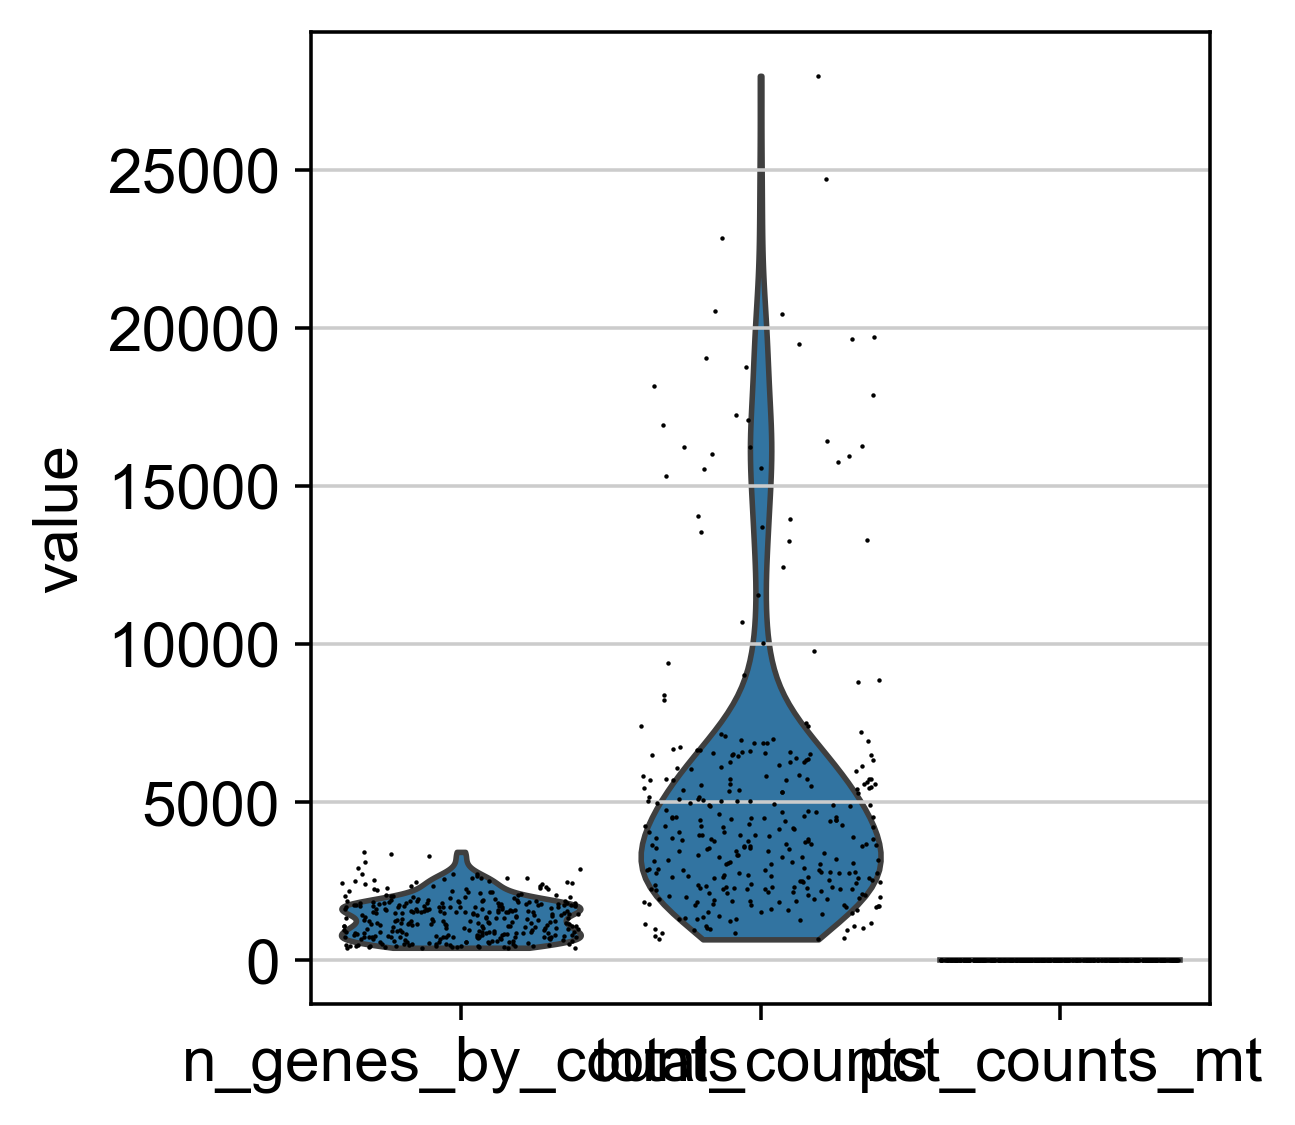

In [ ]:

# Quality Control
# Identify mitochondrial genes based on their names (assuming 'MT-' prefix for mitochondrial genes)

sc.pp.filter_genes(adata, min_cells=3)

# normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate quality control metrics, including mitochondrial content
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Violin plot to visualize quality metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4)

# Filter out low-quality cells and genes
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[:, adata.var.n_cells_by_counts > 3]


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Top 10 highly variable genes: Index(['CST3', 'IGKV1.27', 'IGHV3.11', 'IGHV3.33', 'IGHG3', 'IGHV4.4',
       'IGKV1D.39', 'IGLV1.47', 'TRBV12.3', 'TRBV7.2'],
      dtype='object')


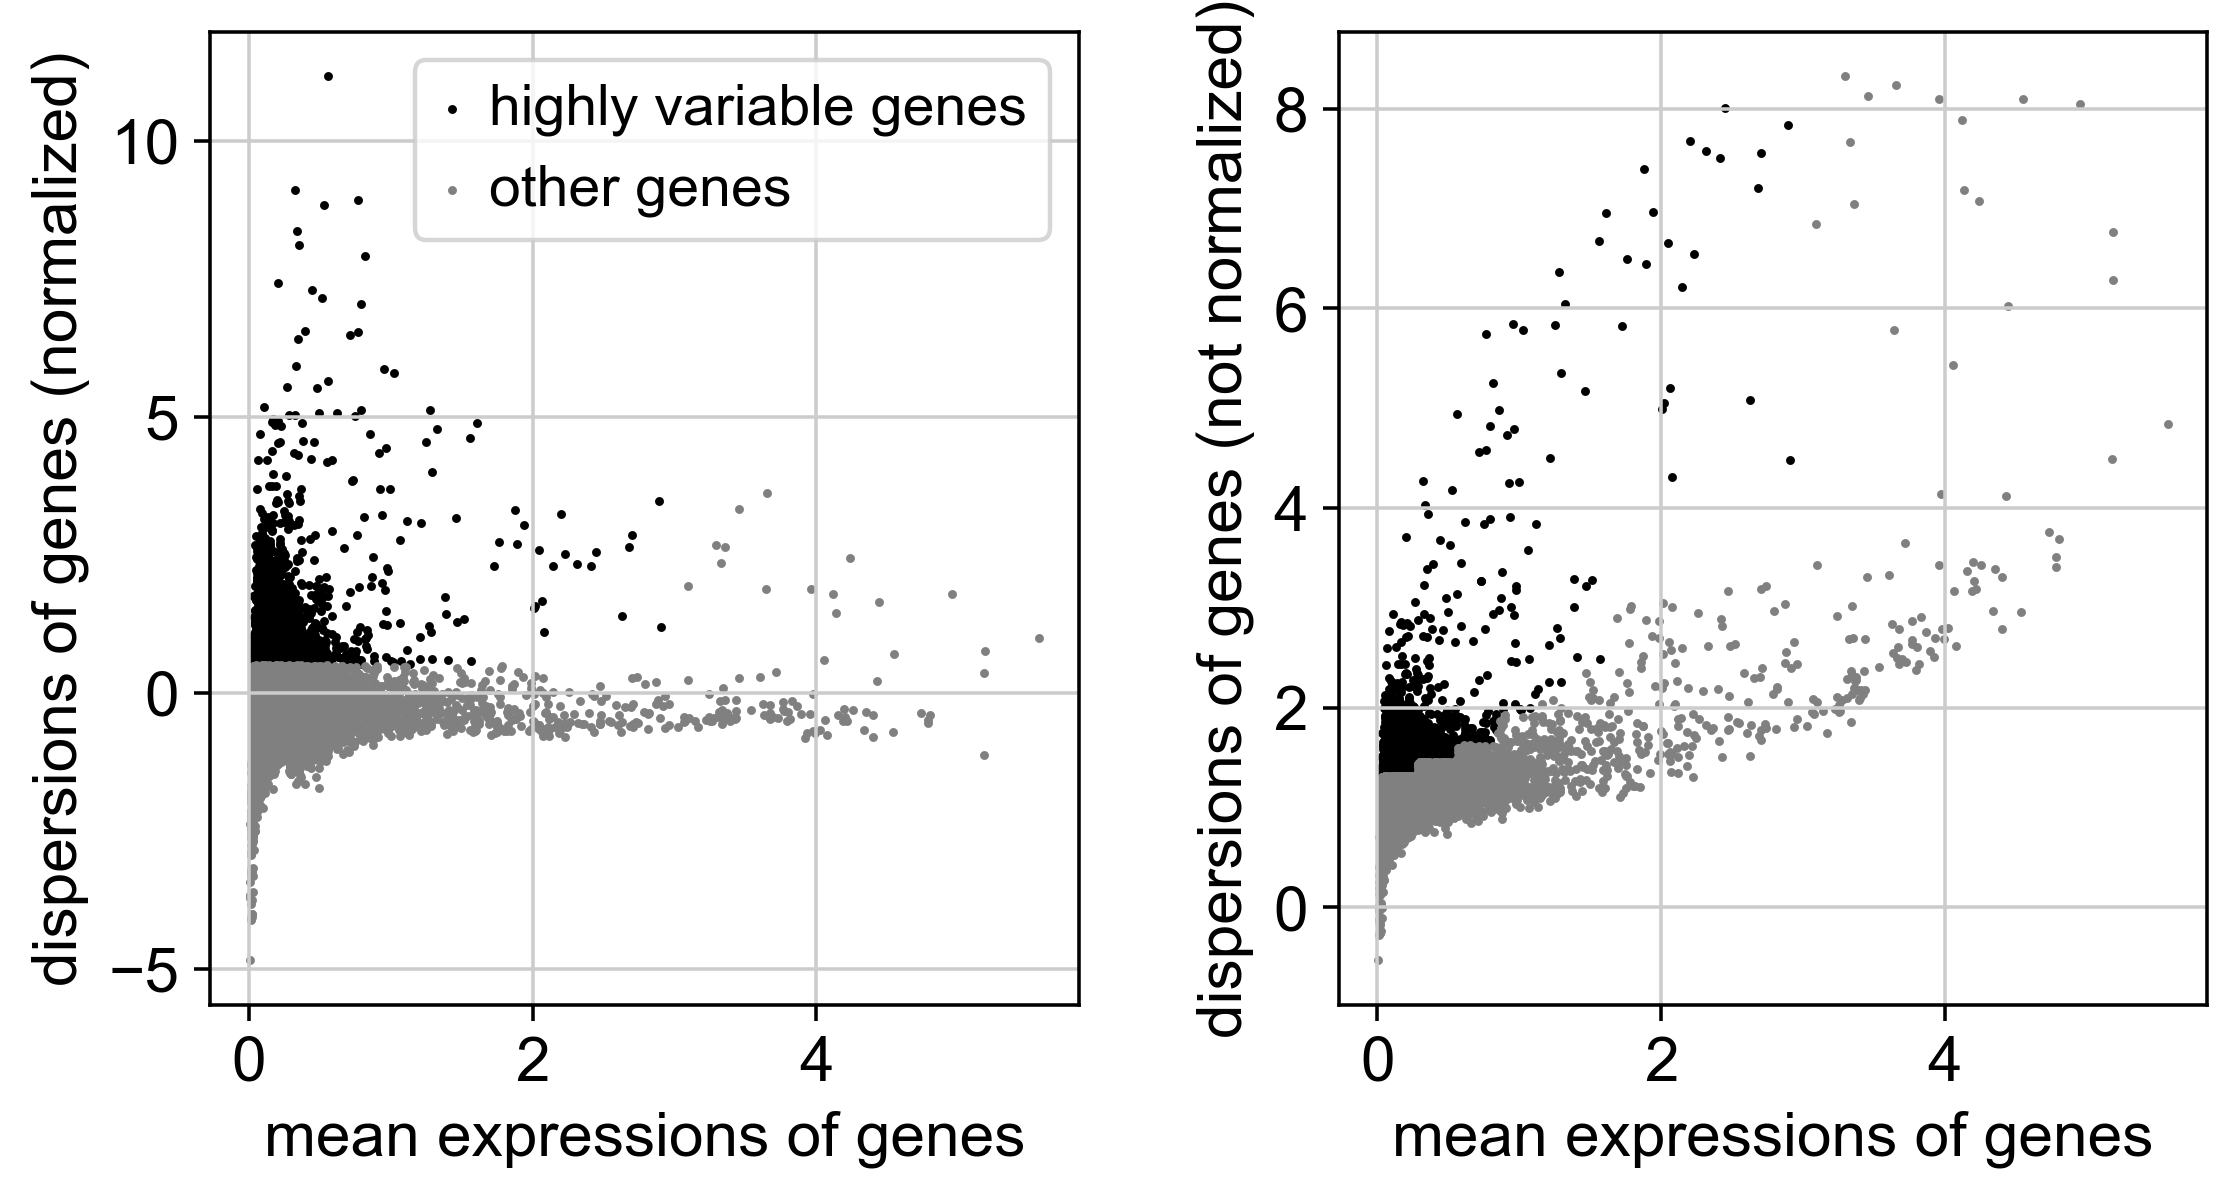

In [55]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Display the top 10 highly variable genes
top10 = adata.var[adata.var['highly_variable']].sort_values(by='dispersions_norm', ascending=False).index[:10]
print("Top 10 highly variable genes:", top10)

# Optional: Plot variable features
sc.pl.highly_variable_genes(adata)

In [56]:
hvg_adata = adata[:, adata.var['highly_variable']].copy()

In [57]:
hvg_adata

AnnData object with n_obs × n_vars = 321 × 2249
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'log1p', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [58]:
hvg_adata.write("hvg_only_adata.h5ad")  

In [59]:
adata = sc.read_h5ad('hvg_only_adata.h5ad')

In [60]:


# Set up scVI model for batch effect correction and dimensionality reduction
# Assuming no batch information in adata.obs, so batch_key=None
scvi.model.SCVI.setup_anndata(adata, batch_key=None)
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=30)  # Train the scVI model

# Use scVI latent space to generate corrected representation
adata.obsm["X_scVI"] = vae.get_latent_representation()
print("Latent representation stored in adata.obsm['X_scVI']")


d:\python3.11\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\python3.11\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\python3.11\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2/30:   3%|▎         | 1/30 [00:00<00:02,  9.72it/s, v_num=1, train_loss_step=854, train_loss_epoch=824]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/30:   7%|▋         | 2/30 [00:00<00:02, 10.51it/s, v_num=1, train_loss_step=854, train_loss_epoch=824]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/30:   7%|▋         | 2/30 [00:00<00:02, 10.51it/s, v_num=1, train_loss_step=828, train_loss_epoch=805]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/30:  10%|█         | 3/30 [00:00<00:02, 10.51it/s, v_num=1, train_loss_step=760, train_loss_epoch=790]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/30:  17%|█▋        | 5/30 [00:00<00:02,  9.81it/s, v_num=1, train_loss_step=794, train_loss_epoch=778]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/30:  17%|█▋        | 5/30 [00:00<00:02,  9.81it/s, v_num=1, train_loss_step=724, train_loss_epoch=766]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/30:  20%|██        | 6/30 [00:00<00:02,  9.35it/s, v_num=1, train_loss_step=809, train_loss_epoch=758]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/30:  23%|██▎       | 7/30 [00:00<00:02,  8.70it/s, v_num=1, train_loss_step=793, train_loss_epoch=749]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/30:  27%|██▋       | 8/30 [00:00<00:02,  8.26it/s, v_num=1, train_loss_step=729, train_loss_epoch=742]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/30:  30%|███       | 9/30 [00:01<00:02,  7.92it/s, v_num=1, train_loss_step=713, train_loss_epoch=735]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/30:  33%|███▎      | 10/30 [00:01<00:02,  7.03it/s, v_num=1, train_loss_step=722, train_loss_epoch=729]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/30:  37%|███▋      | 11/30 [00:01<00:02,  6.87it/s, v_num=1, train_loss_step=761, train_loss_epoch=723]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/30:  40%|████      | 12/30 [00:01<00:02,  6.89it/s, v_num=1, train_loss_step=719, train_loss_epoch=719]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/30:  43%|████▎     | 13/30 [00:01<00:02,  6.92it/s, v_num=1, train_loss_step=711, train_loss_epoch=713]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/30:  47%|████▋     | 14/30 [00:01<00:02,  6.69it/s, v_num=1, train_loss_step=730, train_loss_epoch=709]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/30:  53%|█████▎    | 16/30 [00:02<00:02,  6.23it/s, v_num=1, train_loss_step=726, train_loss_epoch=702]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/30:  60%|██████    | 18/30 [00:02<00:01,  6.49it/s, v_num=1, train_loss_step=701, train_loss_epoch=696]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/30:  63%|██████▎   | 19/30 [00:02<00:01,  6.70it/s, v_num=1, train_loss_step=698, train_loss_epoch=693]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/30:  70%|███████   | 21/30 [00:02<00:01,  6.88it/s, v_num=1, train_loss_step=665, train_loss_epoch=688]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/30:  77%|███████▋  | 23/30 [00:03<00:00,  7.08it/s, v_num=1, train_loss_step=613, train_loss_epoch=683]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/30:  83%|████████▎ | 25/30 [00:03<00:00,  6.47it/s, v_num=1, train_loss_step=707, train_loss_epoch=678]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/30:  90%|█████████ | 27/30 [00:03<00:00,  6.51it/s, v_num=1, train_loss_step=667, train_loss_epoch=675]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/30:  97%|█████████▋| 29/30 [00:04<00:00,  6.55it/s, v_num=1, train_loss_step=650, train_loss_epoch=671]

d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
d:\python3.11\Lib\site-packages\scvi\module\_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/30: 100%|██████████| 30/30 [00:04<00:00,  6.40it/s, v_num=1, train_loss_step=678, train_loss_epoch=669]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [00:04<00:00,  7.04it/s, v_num=1, train_loss_step=678, train_loss_epoch=669]
Latent representation stored in adata.obsm['X_scVI']


In [61]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Filter to keep only HVGs if desired
adata = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


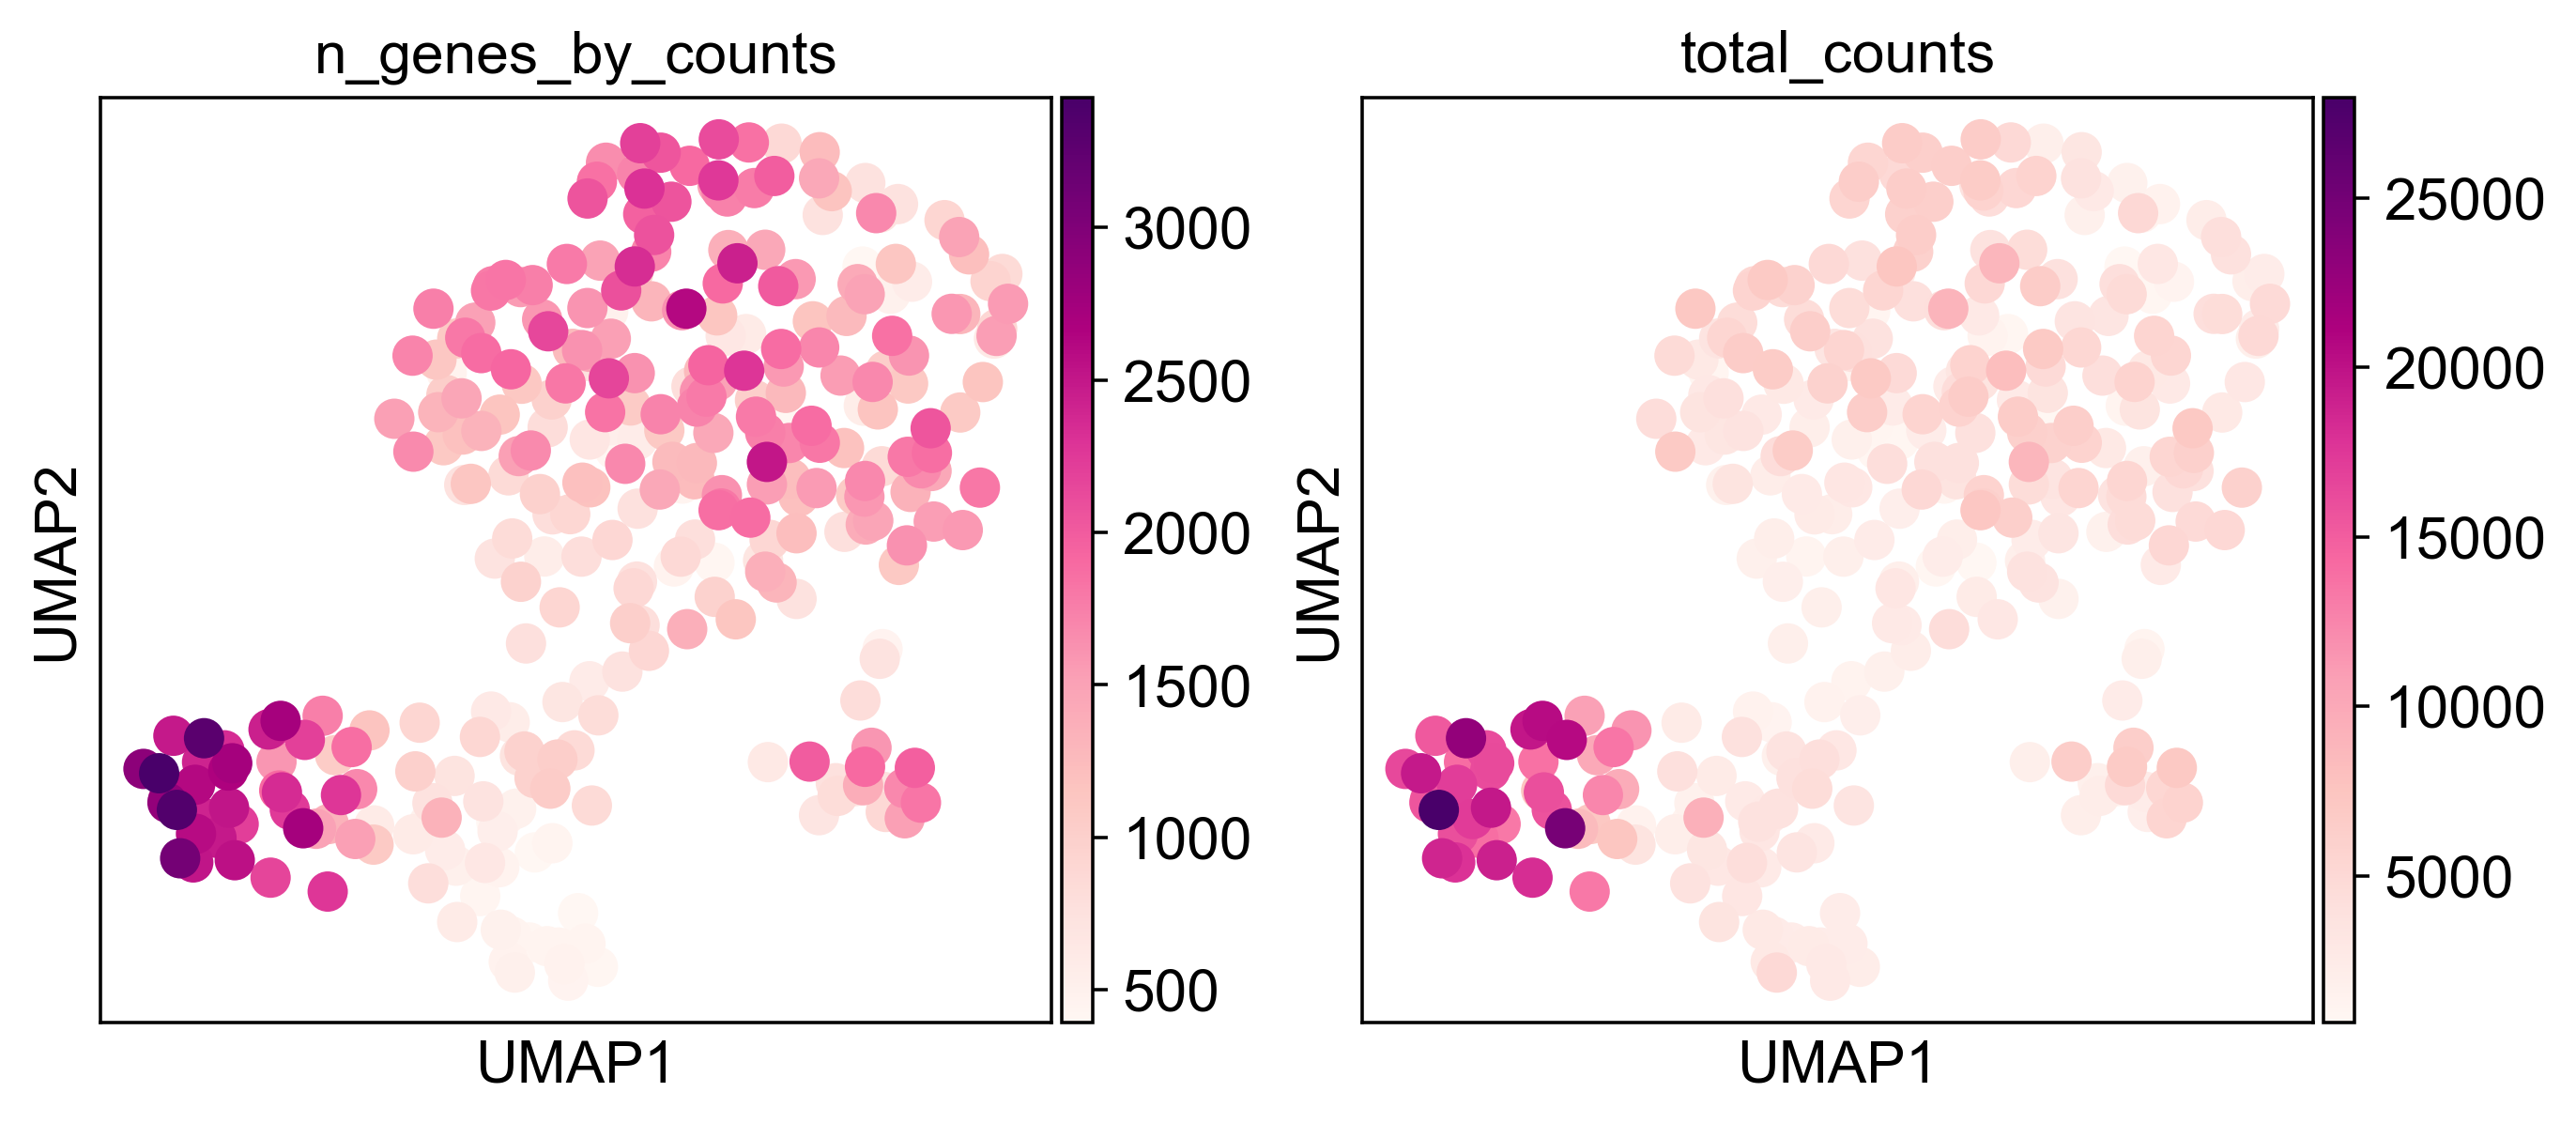

In [62]:

# Use the scVI representation to compute neighbors and UMAP
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)

# Compute UMAP for visualization
sc.tl.umap(adata)
sc.pl.umap(adata, color=["n_genes_by_counts", "total_counts"])


running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


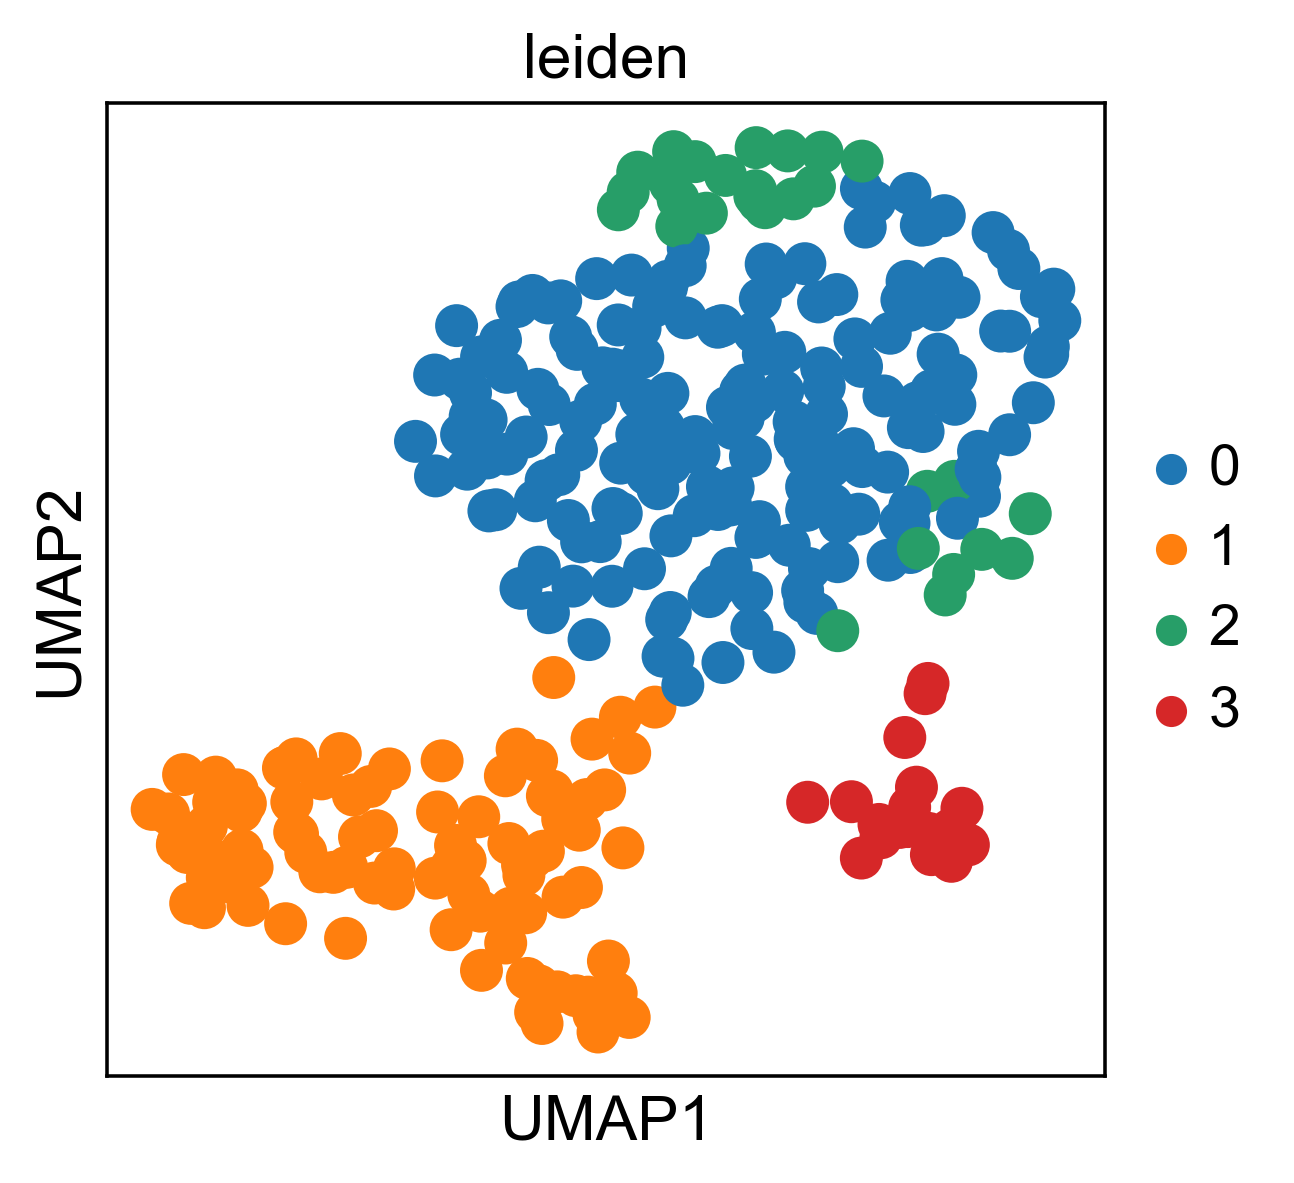

In [63]:

# Perform clustering using the Leiden algorithm on the scVI latent space
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden"])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


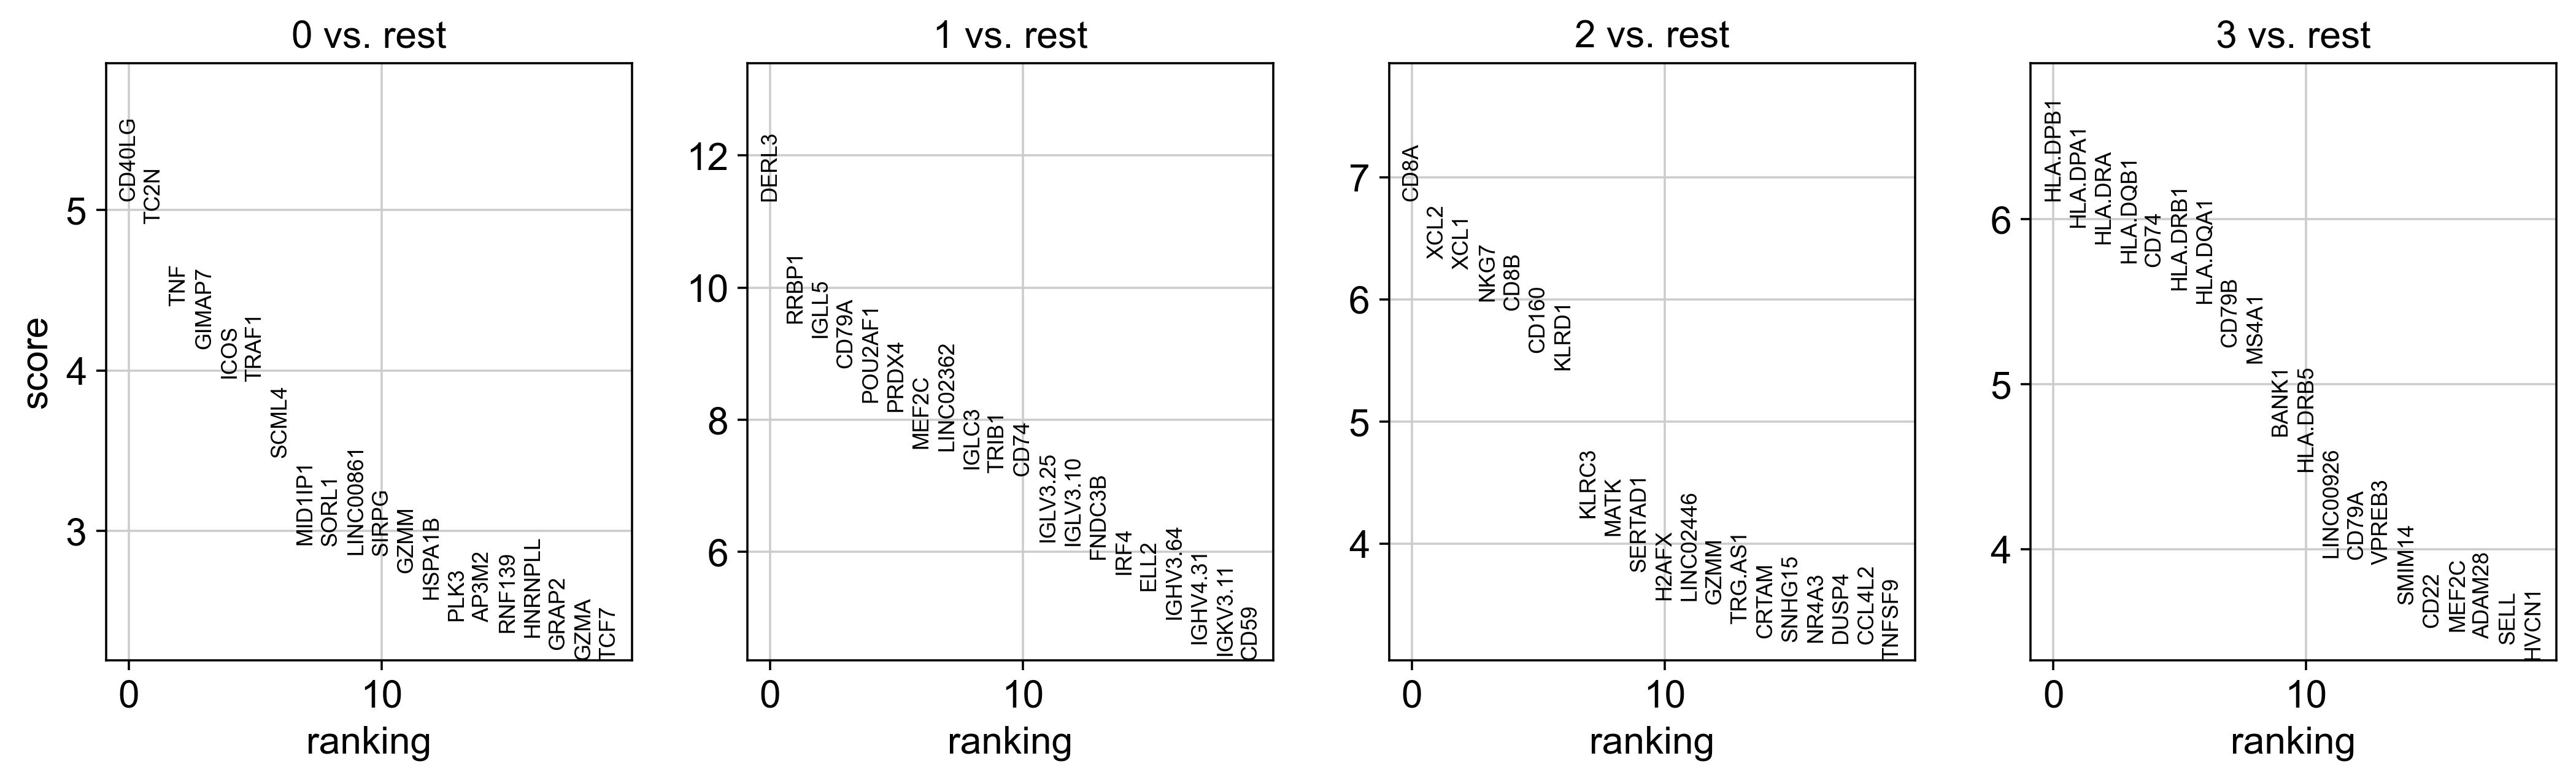

In [64]:

# Differential expression analysis to identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
